# Introduction

This project tries to implement the ResNet architecture with 2,3 skip connections. Here we try to verify the statement from 'Deep Residual Learning for Image Recognition' which states that the learning is better with 2 skip connections rather than 3.


# Packages
Loading the neccessary packages


In [ ]:
!pip install pyyaml h5py 

In [ ]:
import numpy as np
import pandas as pd
import cv2
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.initializers import glorot_uniform
%matplotlib inline
import os

# Index Block

It is the main block of the ResNet architecture. The index block is used in the architecture where there is no change in the input shape and hence forms the major chunk of ResNet. The index block has 2 paths, main and the shortcut path. The main path follows a normal or a general path where the layers are stacked one after the another. The shortcut path is ued to carry the information learnt by the model upto a point and is carried over to a layer which is 2 layers deeper in the model.  

In [ ]:
def index_block(x, f, filters, level, layer):
    
    con_name = str('res' + str(level) + str(layer)) 
    bnz_name = str('bn' + str(level) + str(layer)) 
    
    F1, F2, F3 = filters
    
    x_shortcut = x
    
    x = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = con_name + '2a', kernel_initializer = glorot_uniform(seed=0))(x)
    x = BatchNormalization(axis = 3, name = bnz_name + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = con_name + '2b', kernel_initializer = glorot_uniform(seed=0))(x)
    x = BatchNormalization(axis = 3, name = bnz_name + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = con_name + '2c', kernel_initializer = glorot_uniform(seed=0))(x)
    x = BatchNormalization(axis = 3, name = bnz_name + '2c')(x)

    x = Add()([x, x_shortcut])
    x = Activation('relu')(x)
    
    return x

# Con Block
Con or the convolutional block is the other block which is required to change the sizes of the input shape following the ResNet architecture. Similar to the index block, it has the main and shortcut path's too. The difference is that the shortcut path here has a convolutional layer which changes the size of the input shape to the next layer.


In [ ]:
def con_block(x, f, filters, level, layer, s = 2):

    con_name = str('res' + str(level) + str(layer))
    bnz_name = str('bn' + str(level) + str(layer))
    
    F1, F2, F3 = filters
    
    x_shortcut = x

    x = Conv2D(F1, (1, 1), strides = (s,s), name = con_name + '2a', kernel_initializer = glorot_uniform(seed=0))(x)
    x = BatchNormalization(axis = 3, name = bnz_name + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = con_name + '2b', kernel_initializer = glorot_uniform(seed=0))(x)
    x = BatchNormalization(axis = 3, name = bnz_name + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = con_name + '2c', kernel_initializer = glorot_uniform(seed=0))(x)
    x = BatchNormalization(axis = 3, name = bnz_name + '2c')(x)

    x_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = con_name + '1',
                        kernel_initializer = glorot_uniform(seed=0))(x_shortcut)
    x_shortcut = BatchNormalization(axis = 3, name = bnz_name + '1')(x_shortcut)

    x = Add()([x, x_shortcut])
    x = Activation('relu')(x)
    
    return x

# ResNet1

This defines the architecture of the model with 2 skip connections in the convolutional as well as the index blocks and combined together has a 50 layer deep convolutional neural network.


In [ ]:
def ResNet1(input_shape=(64, 64, 3), classes=6):
    
    x_input = Input(input_shape)

    x = ZeroPadding2D((3, 3))(x_input)

    x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(x)
    x = BatchNormalization(axis=3, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = con_block(x, f=3, filters=[64, 64, 256], layer=2, level='a', s=1)
    x = index_block(x, 3, [64, 64, 256], layer=2, level='b')
    x = index_block(x, 3, [64, 64, 256], layer=2, level='c')

    x = con_block(x, f = 3, filters = [128, 128, 512], layer = 3, level='a', s = 2)
    x = index_block(x, 3, [128, 128, 512], layer=3, level='b')
    x = index_block(x, 3, [128, 128, 512], layer=3, level='c')
    x = index_block(x, 3, [128, 128, 512], layer=3, level='d')

    x = con_block(x, f = 3, filters = [256, 256, 1024], layer = 4, level='a', s = 2)
    x = index_block(x, 3, [256, 256, 1024], level=4, layer='b')
    x = index_block(x, 3, [256, 256, 1024], level=4, layer='c')
    x = index_block(x, 3, [256, 256, 1024], level=4, layer='d')
    x = index_block(x, 3, [256, 256, 1024], level=4, layer='e')
    x = index_block(x, 3, [256, 256, 1024], level=4, layer='f')

    x = con_block(x, f = 3, filters = [512, 512, 2048], level = 5, layer='a', s = 2)
    x = index_block(x, 3, [512, 512, 2048], level=5, layer='b')
    x = index_block(x, 3, [512, 512, 2048], level=5, layer='c')

    x = AveragePooling2D((2,2), name="avg_pool")(x)

    x = Flatten()(x)
    x = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(x)
    
    model = Model(inputs = x_input, outputs = x, name='ResNet50')

    return model

# Compiling

Compiling the model with adam optimizer and using categorical_crossentropy for loss. Accuracy is the metric used to evaluate the model.

In [ ]:
model = ResNet1(input_shape = (64, 64, 3), classes = 10)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

# Loading and Pre Processing

Load the CIFAR10 dataset from keras and assign the variables to the data and labels. Pre process the images with data augmentation and Gaussian blur to improve edge detection.
 

In [ ]:
data=keras.datasets.cifar10

In [ ]:
(train_data,train_label),(test_data,test_label)=data.load_data()

170500096/170498071 [==============================] - 4s 0us/step


In [ ]:
train_label=tf.keras.utils.to_categorical(train_label)
test_label=tf.keras.utils.to_categorical(test_label)

In [ ]:
train_data=train_data/255.0
test_data=test_data/255.0

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
def image_processing1(images):
    processed_images = []
    for image in images: 
            image = image.astype('float32')  
            resized_img = cv2.resize(image, dsize=(64, 64))
            blurred_image=cv2.GaussianBlur(resized_img,(5,5),0)
            processed_images.append(blurred_image)
    return np.array(processed_images)


In [ ]:
train_data=image_processing1(train_data)
test_data=image_processing1(test_data)

In [ ]:
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train = datagen.flow(train_data, train_label, batch_size=64)

# Fitting

Fit the model with ImageDataGenerator which has been used for Data Augmentation and train the model for 25 epochs.

In [ ]:
model1 = model.fit(train, epochs = 60, validation_data=(test_data,test_label))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/60
782/782 [==============================] - 171s 217ms/step - loss: 2.4093 - accuracy: 0.3013 - val_loss: 2.0269 - val_accuracy: 0.2952
Epoch 2/60
782/782 [==============================] - 171s 218ms/step - loss: 1.4941 - accuracy: 0.4833 - val_loss: 102.8753 - val_accuracy: 0.0960
Epoch 3/60
782/782 [==============================] - 170s 217ms/step - loss: 1.4868 - accuracy: 0.4903 - val_loss: 2.1102 - val_accuracy: 0.4837
Epoch 4/60
782/782 [==============================] - 170s 217ms/step - loss: 1.5266 - accuracy: 0.4820 - val_loss: 2.2025 - val_accuracy: 0.3054
Epoch 5/60
782/782 [==============================] - 170s 218ms/step - loss: 1.5733 - accuracy: 0.4669 - val_loss: 1.7797 - val_accuracy: 0.3984
Epoch 6/60
782/782 [==============================] - 170s 217ms/step - loss: 1.3218 - accuracy: 0.5436 - val_loss: 1.8927 - val_accuracy: 0.3244
Epoch 7/60
782/782 [==============================] - 171s 218ms/step - loss: 1.5393 - accuracy: 0.4771 - val_loss: 1.7989

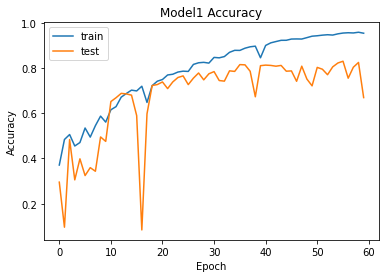

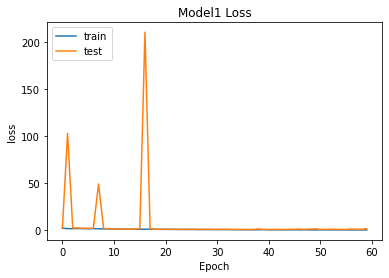

In [ ]:
plt.plot(model1.history['accuracy'])
plt.plot(model1.history['val_accuracy'])
plt.title('Model1 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()
plt.plot(model1.history['loss'])
plt.plot(model1.history['val_loss'])
plt.title('Model1 Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

In [ ]:
model.save('model.h5')